In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

# Set up
sub = 'RC'
save_fig = True

# Manage path
cur_dir = os.getcwd()
project_dir = os.path.dirname(os.path.dirname(cur_dir))
out_dir = os.path.join(cur_dir, 's1_plot_individual')
data_dir = os.path.join(project_dir, 'data', 'uniLoc')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [45]:
# Define a function to format the elements
def format_element(x):
    return float(f"{x[0][0]:.5f}")

In [46]:
# Initialize lists to store data
all_ses = ['A', 'V']
n_ses = len(all_ses)
n_level = 4  # Assuming 4 levels as per the given data
n_rep = 30  # Assuming 30 repetitions as per the given data

# Initialize numpy arrays with the correct dimensions
loc = np.zeros(n_level)
est = np.zeros((n_ses, n_level, n_rep))
err = np.zeros((n_ses, n_level, n_rep))
estMu = np.zeros((n_ses, n_level))
sdMu = np.zeros((n_ses, n_level))
conf = np.zeros((n_ses, n_level, n_rep))

# Load data for each session
for j, session in enumerate(all_ses):
    file_path = os.path.join(data_dir, f'uniLoc_sub-{sub}_ses-{session}.mat')
    if os.path.exists(file_path):
        data = loadmat(file_path)  # Use loadmat to load .mat file
        ExpInfo = np.squeeze(data["ExpInfo"])
        sortedResp = np.squeeze(data['sortedResp'])

        nRep = int(ExpInfo['nRep'].squeeze())
        nLevel = int(ExpInfo['nLevel'].squeeze())

        # target_cm is the true location of the target
        temp_loc = np.array(np.reshape(np.vectorize(format_element)(sortedResp['target_cm']), (nLevel, nRep)))
        loc[:] = temp_loc[:, 0]  # Only take the first repetition because locations are the same for all

        # localization estimates data
        temp_est = np.array(np.reshape(np.vectorize(format_element)(sortedResp['response_cm']), (nLevel, nRep)))
        est[j, :, :] = temp_est

        # Calculate error
        temp_err = temp_est - temp_loc
        err[j, :, :] = temp_err

        # Calculate mean and standard deviation of estimates
        estMu[j, :] = np.mean(temp_est, axis=1)
        sdMu[j, :] = np.std(temp_est.astype(float), axis=1)

        # Confidence data
        temp_conf = np.array(np.reshape(np.vectorize(format_element)(sortedResp['conf_radius_cm']), (nLevel, nRep)))
        conf[j, :, :] = temp_conf

    else:
        print(f"File {file_path} not found.")


## Localization responses

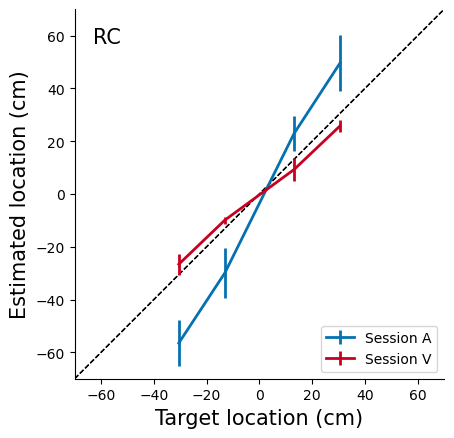

In [47]:
# Plot
lw = 2
fontSZ = 15
titleSZ = 20
clt = np.array([[5, 113, 176], [202, 0, 32]]) / 255  # red and blue
clt_light = np.array([[102, 178, 255], [255, 102, 102]]) / 255  # lighter red and blue

plt.figure()
limax = 70

for i, s in enumerate(all_ses):
    plt.plot([-limax, limax], [-limax, limax], 'k--', linewidth=lw/2)
    e = plt.errorbar(loc, estMu[i,:], yerr=sdMu[i,:], color=clt[i], linewidth=lw, label=f'Session {s}')
    e[0].set_color(clt[i]) 

plt.xlim([-limax, limax])
plt.ylim([-limax, limax])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Target location (cm)', fontsize=fontSZ)
plt.ylabel('Estimated location (cm)', fontsize=fontSZ)

# Add legend at the bottom right
plt.legend(loc='lower right')

# Remove the upper and right axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add the subject identifier at the top left corner
plt.text(0.05, 0.95, sub, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=fontSZ)

if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_uni_loc.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()

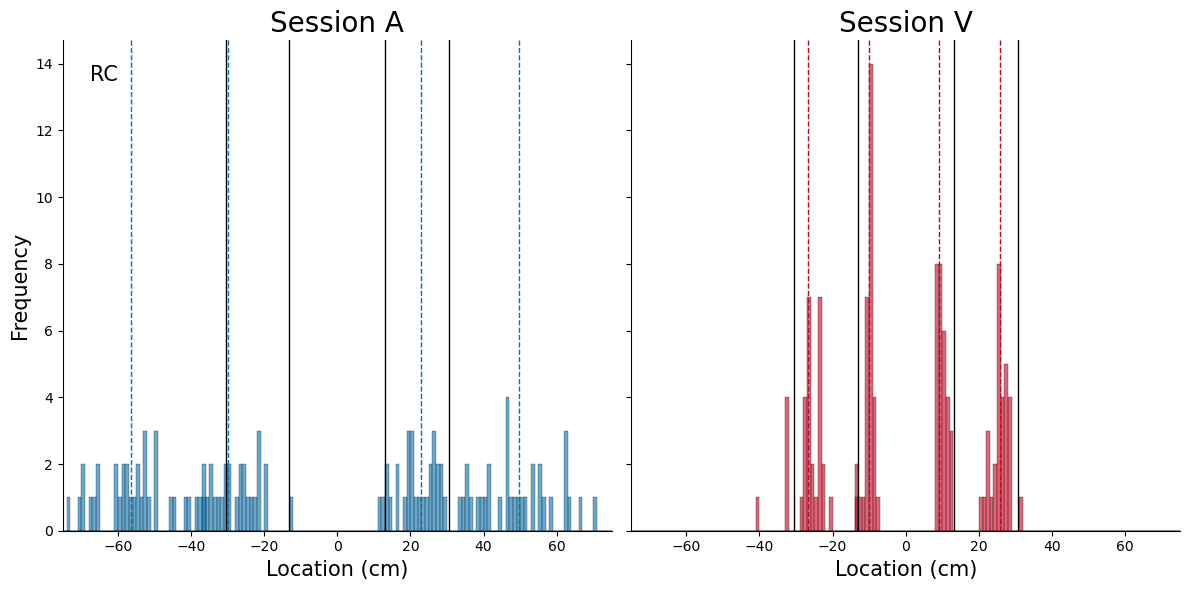

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

bin_width = 1
bins = np.arange(-75, 76, bin_width)
for ss, ses in enumerate(all_ses):
    est_s = est[ss]
    for ii in range(n_level):
        sns.histplot(est_s[ii], bins=bins, kde=False, ax=axes[ss], color=clt[ss], alpha=0.6)
        axes[ss].axvline(loc[ii], color='black', linestyle='-', linewidth=1)
        axes[ss].axvline(np.mean(est_s[ii]), color=clt[ss], linestyle='--', linewidth=1)

    axes[ss].set_xlim([-75, 75])
    axes[ss].set_xlabel('Location (cm)', fontsize=fontSZ)
    axes[ss].set_ylabel('Frequency', fontsize=fontSZ)
    axes[ss].spines['top'].set_visible(False)
    axes[ss].spines['right'].set_visible(False)
    axes[ss].set_title(f'Session {ses}', fontsize=titleSZ)

    if ss == 0:
        axes[ss].text(0.05, 0.95, sub, horizontalalignment='left', verticalalignment='top', transform=axes[ss].transAxes, fontsize=fontSZ)

plt.tight_layout()
if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_loc_hist.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()


## Violin plot of the Confidence radiuss

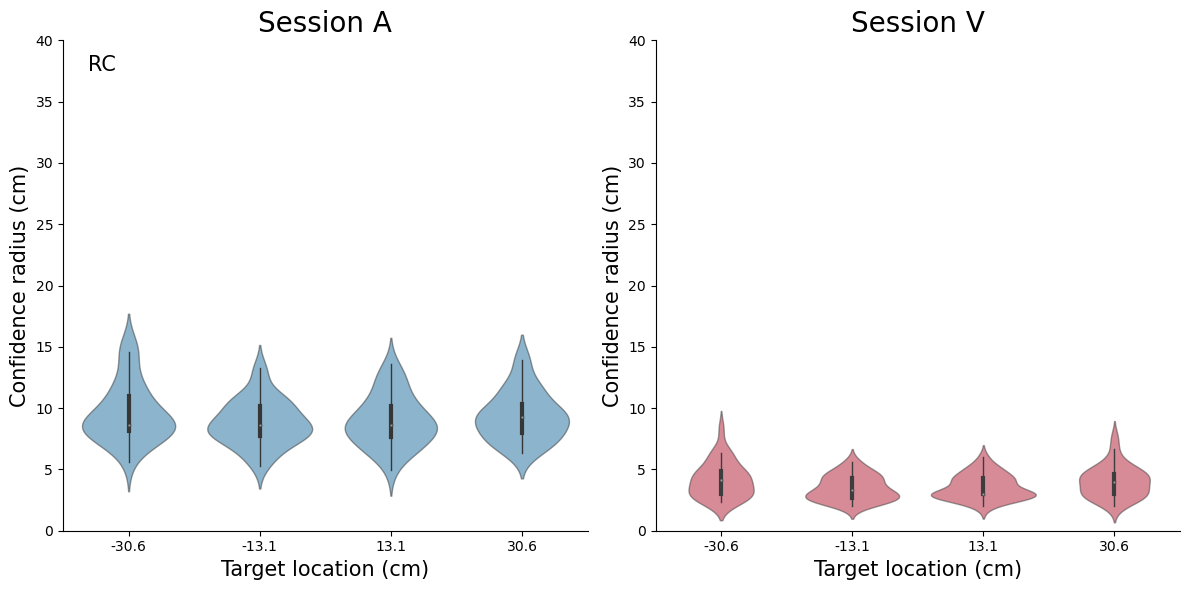

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 subplot

for idx, s in enumerate(all_ses):
    conf_s = conf[idx]
    sns.violinplot(data=[conf_s[i, :].flatten() for i in range(n_level)], linewidth=1, palette=[clt[idx]], ax=axes[idx])

    # Set transparency level
    plt.setp(axes[idx].collections, alpha=.5)

    # Use loc for session 's' as x-axis labels
    axes[idx].set_xticks(range(len(loc)))
    axes[idx].set_xticklabels([f'{l:.1f}' for l in loc])
    axes[idx].set_ylim([0, 40])
    axes[idx].set_xlabel('Target location (cm)', fontsize=fontSZ)
    axes[idx].set_ylabel('Confidence radius (cm)', fontsize=fontSZ)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].set_title(f'Session {s}', fontsize=titleSZ)
    if idx == 0:
        axes[idx].text(0.1, 0.97, sub, horizontalalignment='right', verticalalignment='top', transform=axes[idx].transAxes, fontsize=fontSZ)

plt.tight_layout()
if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_uni_conf.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()


## Examine metacognitive sensitivity of unimodal localization

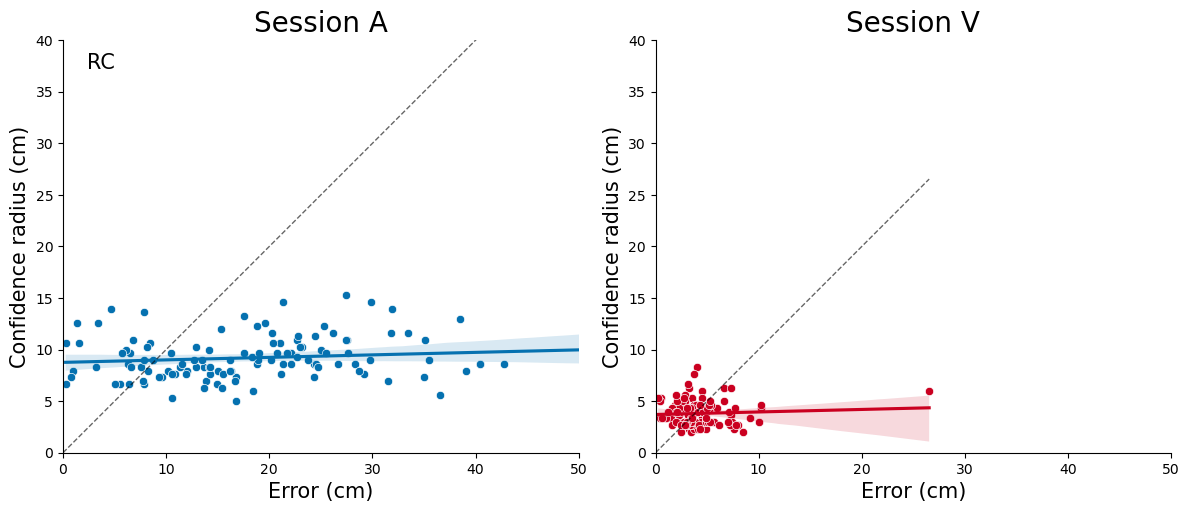

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a 1x2 subplot

for idx, s in enumerate(all_ses):
    session_index = all_ses.index(s)
    err_s = np.abs(err[idx].flatten())
    conf_s = conf[idx].flatten()

    sns.scatterplot(x=err_s, y=conf_s, ax=axes[idx], color=clt[idx])
    sns.regplot(x=err_s, y=conf_s, ax=axes[idx], scatter=False, color=clt[idx])

    # Add identity line
    max_val = max(err_s.max(), conf_s.max())
    axes[idx].plot([0, max_val], [0, max_val], 'k--', linewidth=1,alpha = 0.6)

    axes[idx].set_xlabel('Error (cm)', fontsize=fontSZ)
    axes[idx].set_ylabel('Confidence radius (cm)', fontsize=fontSZ)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].set_ylim([0, 40])
    axes[idx].set_xlim([0, 50])
    axes[idx].set_title(f'Session {s}', fontsize=titleSZ)
    axes[idx].set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal

    if idx == 0:
        axes[idx].text(0.1, 0.97, sub, horizontalalignment='right', verticalalignment='top', transform=axes[idx].transAxes, fontsize=fontSZ)

plt.tight_layout()
if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_err_conf_corr.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()

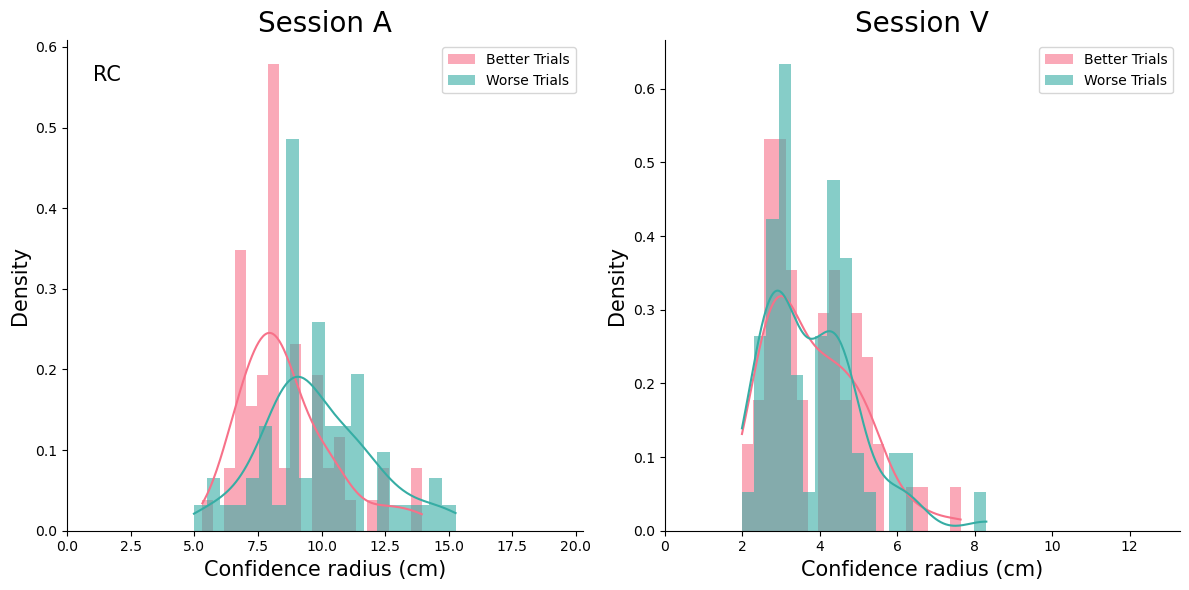

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False) 

# Define the color palette
palette = sns.color_palette("husl", 2)

for idx, s in enumerate(all_ses):
    session_index = all_ses.index(s)
    err_s = np.abs(err[idx].flatten())
    conf_s = conf[idx].flatten()

    # Determine the threshold for better and worse trials
    threshold = np.median(err_s)

    # Separate trials based on error size
    better_trials = conf_s[err_s <= threshold]
    worse_trials = conf_s[err_s > threshold]

    # Plot histogram with density curve for better trials
    sns.histplot(better_trials, kde=True, color=palette[0], ax=axes[idx], label='Better Trials', stat='density', bins=20, alpha=0.6, edgecolor=None)

    # Plot histogram with density curve for worse trials
    sns.histplot(worse_trials, kde=True, color=palette[1], ax=axes[idx], label='Worse Trials', stat='density', bins=20, alpha=0.6, edgecolor=None)

    axes[idx].set_xlabel('Confidence radius (cm)', fontsize=fontSZ)
    axes[idx].set_ylabel('Density', fontsize=fontSZ)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].set_title(f'Session {s}', fontsize=titleSZ)
    axes[idx].legend()

    # Set x-axis limits
    max_conf = np.max(conf_s)
    axes[idx].set_xlim(0, max_conf + 5)

    # Add participant ID to session A's panel
    if s == 'A':
        axes[idx].text(0.05, 0.95, sub, horizontalalignment='left', verticalalignment='top', transform=axes[idx].transAxes, fontsize=fontSZ)

plt.tight_layout()
if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_conf_hist.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()


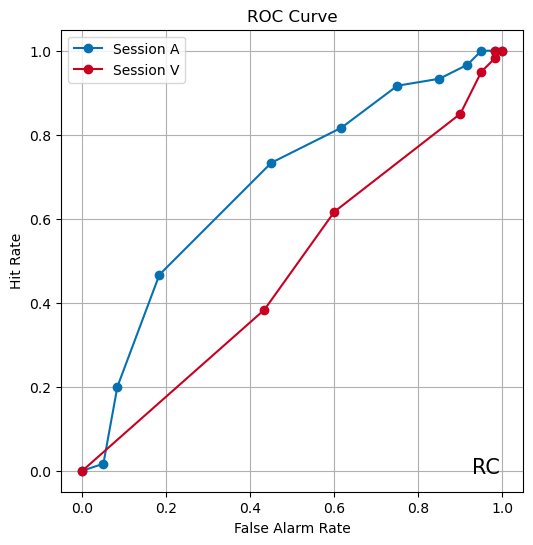

In [52]:
# Define the function to compute and plot ROC curve
def plot_roc_curve(better_trials, worse_trials, session_label, color):
    min_conf = min(min(better_trials), min(worse_trials))
    max_conf = max(max(better_trials), max(worse_trials))
    plt.gca().set_aspect('equal', adjustable='box')
    criteria = np.arange(min_conf, max_conf + 1, 1)

    hit_rates = []
    fa_rates = []

    for criterion in criteria:
        hits = np.sum(better_trials < criterion)
        false_alarms = np.sum(worse_trials < criterion)

        hit_rate = hits / len(better_trials)
        fa_rate = false_alarms / len(worse_trials)

        hit_rates.append(hit_rate)
        fa_rates.append(fa_rate)

    plt.plot(fa_rates, hit_rates, marker='o', label=f'Session {session_label}', color=color)
    plt.xlabel('False Alarm Rate')
    plt.ylabel('Hit Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curves for both sessions
plt.figure(figsize=(10, 6))
for idx, s in enumerate(all_ses):
    session_index = all_ses.index(s)
    err_s = np.abs(err[idx].flatten())
    conf_s = conf[idx].flatten()

    # Determine the threshold for better and worse trials
    threshold = np.median(err_s)

    # Separate trials based on error size
    better_trials = conf_s[err_s <= threshold]
    worse_trials = conf_s[err_s > threshold]

    plot_roc_curve(better_trials, worse_trials, s, clt[idx])

# Add the subject identifier at the right bottom corner
plt.text(0.95, 0.03, sub, horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=fontSZ)

if save_fig:
    fig_path = os.path.join(out_dir, f'{sub}_roc_curve.png')
    plt.savefig(fig_path, bbox_inches='tight')

plt.show()
